In [2]:
import tensorflow as tf
import keras
from PIL import Image
import glob, os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [75]:
path = 'C:/Users/AVIK/Documents/Udacity Self Driving Cars/CarND-Behavioral-Cloning-P3-master/examples/data/'

df_log = pd.read_csv(path+"driving_log.csv")
print("Number of examples {}".format(len(df_log)))
df_log.head()

Number of examples 8036


,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


(array([  4.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.10000000e+01,   8.00000000e+01,
          1.80000000e+02,   2.14000000e+02,   8.11000000e+02,
          4.95600000e+03,   6.93000000e+02,   7.12000000e+02,
          1.76000000e+02,   1.28000000e+02,   3.80000000e+01,
          6.00000000e+00,   5.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   2.00000000e+00]),
 array([-0.9426954 , -0.84556063, -0.74842586, -0.65129109, -0.55415632,
        -0.45702155, -0.35988678, -0.26275201, -0.16561724, -0.06848247,
         0.0286523 ,  0.12578707,  0.22292184,  0.32005661,  0.41719138,
         0.51432615,  0.61146092,  0.70859569,  0.80573046,  0.90286523,  1.        ]),
 <a list of 20 Patch objects>)

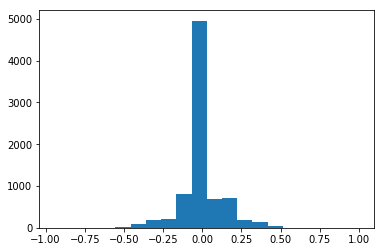

In [94]:
plt.hist(df_log["steering"],20)

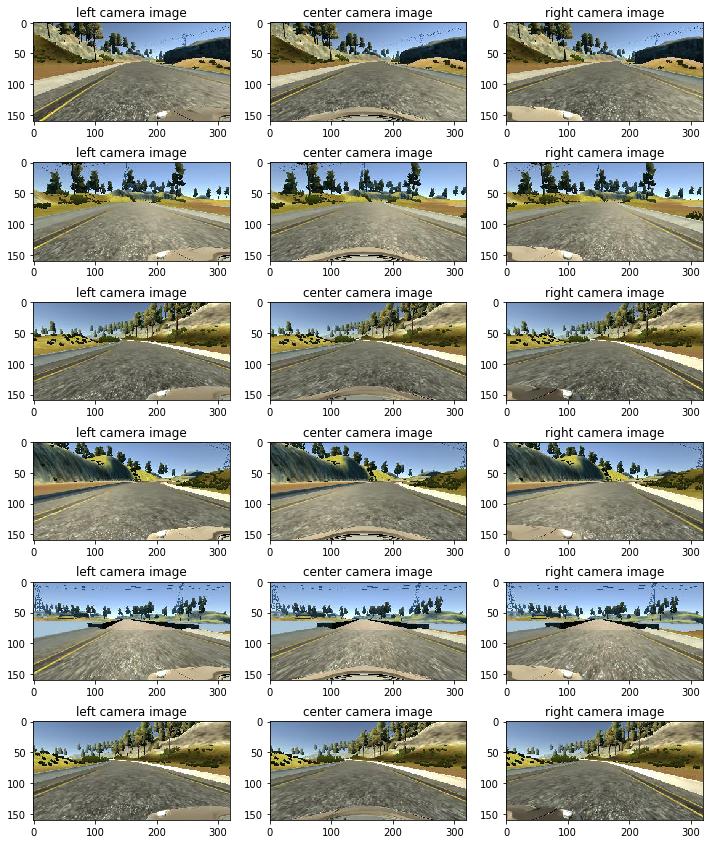

In [86]:
#infile = glob.glob(path+"IMG/*.jpg")

fig,ax = plt.subplots(6,3, figsize= (12,15))
ax = ax.ravel()
example_images = []
example_images_idx = []
for kk in range(6):
    rand_img_idx = np.random.randint(len(df_log))
    left_image_file = df_log['left'][rand_img_idx]
    center_image_file = df_log['center'][rand_img_idx] 
    right_image_file = df_log['right'][rand_img_idx]
    image = plt.imread(path+left_image_file[1:])
    image = np.asarray(image)
    ax[3*kk].imshow(image,cmap="gray")
    ax[3*kk].set_title("left camera image")
    image = plt.imread(path+center_image_file)
    image = np.asarray(image)
    ax[3*kk+1].imshow(image,cmap="gray")
    ax[3*kk+1].set_title("center camera image")
    example_images.append(image)
    example_images_idx.append(rand_img_idx)
    image = plt.imread(path+right_image_file[1:])
    image = np.asarray(image)
    ax[3*kk+2].imshow(image,cmap="gray")
    ax[3*kk+2].set_title("right camera image")


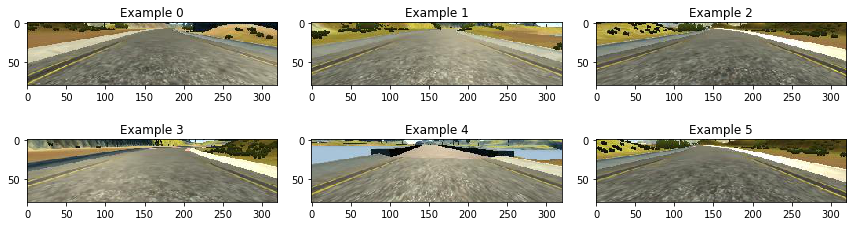

In [88]:
remove_top_pixels = 55
remove_bottom_pixels = 25
mod_example_images = []

fig, ax = plt.subplots(2,3,figsize=(12,5))
ax = ax.ravel()
for ii in range(6):
    cropped_images = example_images[ii]
    image_resized = cropped_images[remove_top_pixels:-remove_bottom_pixels,:,:]
    plt.subplot(3,3,ii+1)
    plt.imshow(image_resized, cmap="gray")
    plt.title("Example {}".format(ii+1))
    mod_example_images.append(image_resized)

plt.tight_layout()
plt.show()

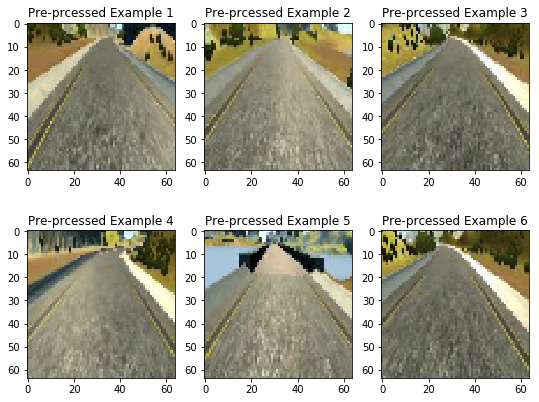

In [122]:
import cv2
WIDTH, HEIGHT = 64,64
fig,ax = plt.subplots(2,3,figsize=(9,7)) 
ax = ax.ravel()
for ii in range(6):
    image = cv2.resize(mod_example_images[ii],(WIDTH,HEIGHT))
    #image = (image-128)/256
    ax[ii].imshow(image,cmap="gray")
    ax[ii].set_title("Pre-processed Example {}".format(ii+1))

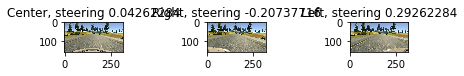

In [139]:
CORRECTION = 0.25 

ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
left_image_file = df_log['left'][example_images_idx[ii]]
right_image_file = df_log['right'][example_images_idx[ii]]        
center_image = plt.imread(path+center_image_file)
left_image = plt.imread(path+left_image_file[1:])
right_image = plt.imread(path+right_image_file[1:])
center_steering = df_log['steering'][example_images_idx[ii]]
right_steering = df_log['steering'][example_images_idx[ii]]-CORRECTION
left_steering = df_log['steering'][example_images_idx[ii]]+CORRECTION
plt.subplot(1,3,1)
plt.imshow(center_image)
plt.title("Center, steering {}".format(center_steering))
plt.subplot(1,3,2)
plt.imshow(right_image)
plt.title("Right, steering {}".format(right_steering))
plt.subplot(1,3,3)
plt.imshow(left_image)
plt.title("Left, steering {}".format(left_steering))  
plt.tight_layout()
plt.show()


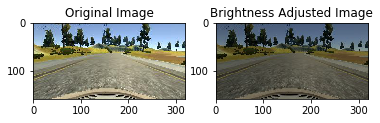

In [179]:
ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
center_image = plt.imread(path+center_image_file)
center_image_mod = cv2.cvtColor(center_image,cv2.COLOR_RGB2HSV)
random_bright = .25+np.random.uniform()
center_image_mod[:,:,2] = center_image_mod[:,:,2]*random_bright
center_image_mod = cv2.cvtColor(center_image_mod,cv2.COLOR_HSV2RGB)
plt.subplot(1,2,1)
plt.imshow(center_image)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(center_image_mod)
plt.title("Brightness Adjusted Image")

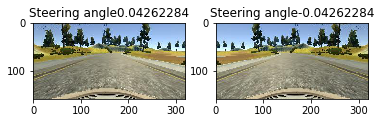

In [167]:
ii = 1
center_image_file = df_log['center'][example_images_idx[ii]]
center_image = plt.imread(path+center_image_file)
center_steering = df_log['steering'][example_images_idx[ii]]
center_image_mod = cv2.flip(center_image,1)
center_steering_mod = center_steering*-1.0
plt.subplot(1,2,1)
plt.imshow(center_image)
plt.title("Steering angle{}".format(center_steering))
plt.subplot(1,2,2)
plt.imshow(center_image_mod)
plt.title("Steering angle{}".format(center_steering_mod))